# BI-LSTM Model

In [1]:
#Imports
import pandas as pd
import numpy as np

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.models import Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

##### 1)Loading Dataset

In [2]:
df_train=pd.read_csv("training_GPT.csv")
df_test=pd.read_csv("testing_GPT.csv")

In [3]:
df_train.isnull().sum()

Unnamed: 0.2              0
Unnamed: 0.1              0
Unnamed: 0                0
text                      0
label                     0
length                    0
preprocessed_abstract    11
length_after_cleaning     0
tokenized_text            0
dtype: int64

In [4]:
df_test.isnull().sum()

Unnamed: 0.2             0
Unnamed: 0.1             0
Unnamed: 0               0
text                     0
label                    0
length                   0
preprocessed_abstract    6
length_after_cleaning    0
tokenized_text           0
dtype: int64

In [5]:
df_train=df_train.dropna()
df_test=df_test.dropna()

##### 2)Preparing Data

- Word2Vec model (pre-trained word embeddings) for embedding layer in the model

In [6]:
preprocessed_abstract=pd.concat([df_train['preprocessed_abstract'],df_test['preprocessed_abstract']], axis=0, ignore_index=True)

In [7]:
sentences = [sentence.split() for sentence in preprocessed_abstract]
# Create and train the Word2Vec model
model_2= Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
# Access the word vectors
word_vectors = model_2.wv
word_vectors.vectors

array([[-6.76495910e-01, -5.94803154e-01,  3.60650390e-01, ...,
        -1.66272485e+00,  1.25219589e-02,  6.24123991e-01],
       [-1.10437977e+00,  7.04761505e-01,  1.50604582e+00, ...,
        -5.16818404e-01, -2.94797599e-01, -3.57697874e-01],
       [-2.99742639e-01,  3.42702091e-01,  5.00845276e-02, ...,
        -1.03573710e-01,  4.48082626e-01, -1.29210198e+00],
       ...,
       [-1.34961018e-02,  1.97726768e-03, -4.22131317e-03, ...,
        -4.20168368e-03, -6.37520279e-04, -4.40633995e-03],
       [-5.10449847e-03, -1.03582777e-02, -1.49481185e-02, ...,
         2.88217375e-03, -1.20837439e-03,  1.43594388e-02],
       [-6.77296240e-03,  1.30136134e-02,  1.18528791e-02, ...,
        -1.30484775e-02, -3.99098312e-03, -1.25016784e-02]], dtype=float32)

In [8]:
word_vectors.vectors.shape

(14336, 100)

#####  3) Split , into Training and Validation Sets (80:20)

In [9]:
X_train=df_train['preprocessed_abstract']
X_test=df_test['preprocessed_abstract']
y_train=df_train['label']
y_test=df_test['label']

In [10]:
print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (21978,) (21978,)
Test data: (5501,) (5501,)


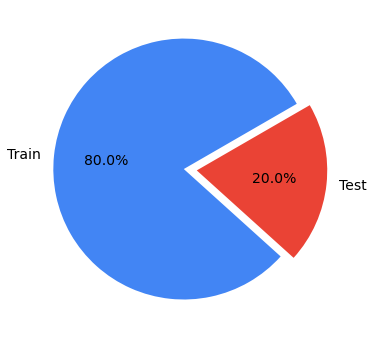

In [11]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(y_train), len(y_test)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0.05),
        startangle=30);

In [12]:
corp=X_train
t = Tokenizer()
t.fit_on_texts(corp)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(corp)
# print(encoded_docs)
max_length=max(len(d) for d in encoded_docs)
padded_docs_train = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs_train)

[[ 329  358 2650 ...    0    0    0]
 [   8 6457  289 ...    0    0    0]
 [ 489  146 1762 ...    0    0    0]
 ...
 [ 176  278 2514 ...    0    0    0]
 [  28  157   22 ...    0    0    0]
 [1135   21    4 ...    0    0    0]]


In [13]:
corp=X_test
t = Tokenizer()
t.fit_on_texts(corp)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(corp)
# print(encoded_docs)
padded_docs_test = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs_test)

[[  57   51    0 ...    0    0    0]
 [ 275  187 1222 ...    0    0    0]
 [   1   54  586 ...    0    0    0]
 ...
 [5669   48    1 ...    0    0    0]
 [1646  355 2049 ...    0    0    0]
 [2835   87   42 ...    0    0    0]]


##### 4)Model Architecture

In [14]:
model = Sequential()
model.add(Embedding(word_vectors.vectors.shape[0],100, input_length=max_length))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(3, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 100)           1433600   
                                                                 
 bidirectional (Bidirection  (None, 256)               234496    
 al)                                                             
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 1668867 (6.37 MB)
Trainable params: 1668867 (6.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

##### 5) Training Model

In [17]:
history=model.fit(padded_docs_train, y_train, epochs=10, batch_size=64, validation_data=(padded_docs_test, y_test))
history

Epoch 1/10


344/344 [==============================] - 26s 55ms/step - loss: 0.4609 - accuracy: 0.8059 - val_loss: 2.6842 - val_accuracy: 0.2458
Epoch 2/10
344/344 [==============================] - 18s 52ms/step - loss: 0.2501 - accuracy: 0.9061 - val_loss: 3.2521 - val_accuracy: 0.2550
Epoch 3/10
344/344 [==============================] - 18s 54ms/step - loss: 0.1802 - accuracy: 0.9349 - val_loss: 3.5928 - val_accuracy: 0.2585
Epoch 4/10
344/344 [==============================] - 19s 55ms/step - loss: 0.1410 - accuracy: 0.9497 - val_loss: 3.6163 - val_accuracy: 0.2625
Epoch 5/10
344/344 [==============================] - 19s 54ms/step - loss: 0.1130 - accuracy: 0.9610 - val_loss: 4.1520 - val_accuracy: 0.2587
Epoch 6/10
344/344 [==============================] - 18s 51ms/step - loss: 0.0940 - accuracy: 0.9666 - val_loss: 4.7634 - val_accuracy: 0.2650
Epoch 7/10
344/344 [==============================] - 18s 52ms/step - loss: 0.0814 - accuracy: 0.9702 - val_loss: 4.2562 - val_accurac

##### 6) Finding Training and Testing Accuracy

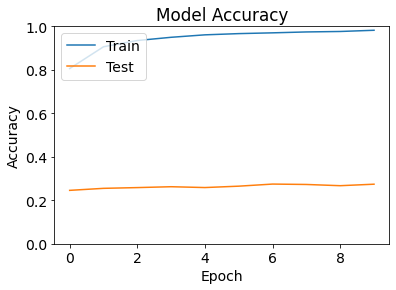

In [18]:
# Plot the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
test_loss,test_acc=model.evaluate(padded_docs_test,y_test)
test_loss,test_acc

172/172 [==============================] - 1s 9ms/step - loss: 5.3172 - accuracy: 0.2741


(5.317221164703369, 0.27413198351860046)

##### 7) Compute and plot the confusion matrix for the three classes

In [20]:
predictions=model.predict(padded_docs_test)
class_labels = ['negative', 'positive','neutral']
predicted_class_labels = [class_labels[np.argmax(pred)] for pred in predictions]
actual_class_labels=[class_labels[actual] for actual in y_test]
print(classification_report(actual_class_labels, predicted_class_labels))

172/172 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

    negative       0.63      0.19      0.30      3447
     neutral       0.22      0.52      0.31      1154
    positive       0.13      0.26      0.18       900

    accuracy                           0.27      5501
   macro avg       0.33      0.33      0.26      5501
weighted avg       0.46      0.27      0.28      5501



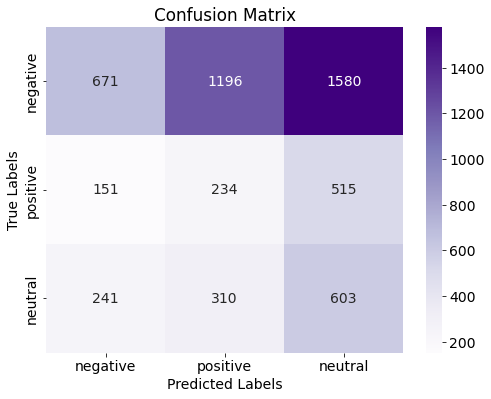

In [21]:
conf_matrix = confusion_matrix(actual_class_labels, predicted_class_labels, labels=class_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

##### 8) Saving the final results in Excel sheet

In [22]:
precision_per_class = precision_score(actual_class_labels, predicted_class_labels, average=None)
recall_per_class = recall_score(actual_class_labels, predicted_class_labels, average=None)

print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)

Precision per class: [0.63123236 0.22349889 0.13448276]
Recall per class: [0.19466202 0.52253033 0.26      ]


In [23]:
f1_micro = f1_score(actual_class_labels, predicted_class_labels, average='micro')
f1_macro = f1_score(actual_class_labels, predicted_class_labels, average='macro')

print("Micro F1 Score:", f1_micro)
print("Macro F1 Score:", f1_macro)

Micro F1 Score: 0.27413197600436284
Macro F1 Score: 0.2626392716773387


In [24]:
result=pd.read_csv('BILSTMModelResults.csv')
result['GPT3.5_Dataset']=[max(history.history['accuracy']),test_acc,f1_micro,f1_macro,precision_per_class[0],precision_per_class[1],precision_per_class[2],recall_per_class[0],recall_per_class[1],recall_per_class[2]]
result[['Unnamed: 0','GPT3.5_Dataset']]

,Unnamed: 0,GPT3.5_Dataset
0,Training Accuracy,0.982027
1,Testing Accuracy,0.274132
2,Micro F1 Score,0.274132
3,Macro F1 Score,0.262639
4,Precision for Negative sentiment,0.631232
5,Precision for Positive sentiment,0.223499
6,Precision for Neutral sentiment,0.134483
7,Recall for Negative sentiment,0.194662
8,Recall for Positive sentiment,0.522530
9,Recall for Neutral sentiment,0.260000


In [25]:
result.to_csv('BILSTMModelResults.csv', index=False)